In [1]:
import json
import os
import itertools
import pandas as pd
import numpy as np
import re
from datetime import datetime as dt
import seaborn as sns

import sys
sys.path.append(".\\sample")
from SALibRepastParams import num_levels, params, random_seed, init_problem, calc_second_order, policies

import batch_data_utils as bd_utils

In [2]:
with open(".//config.json") as f:
    config = json.load(f)

In [3]:
file_datetime_string = config['file_datetime_string']
vehicle_density_timestamp = config['vehicle_density_timestamp']
setting = config['setting']

gis_data_dir = os.path.abspath("..\\data\\model_gis_data")
data_dir = config['batch_data_dir']
img_dir = "..\\output\\img\\"

In [4]:
output_paths = bd_utils.get_ouput_paths(file_datetime_string, vehicle_density_timestamp, data_dir)
output_sd_data = output_paths["output_sd_data"]

In [5]:
output_sd_data

'C:\\Users\\obisargoni\\eclipse-workspace\\repastInterSim\\output\\batch\\model_run_data\\metrics_for_sd_analysis.2022.Apr.21.14_56_46.csv'

In [6]:
dfDD = pd.read_csv(output_sd_data)

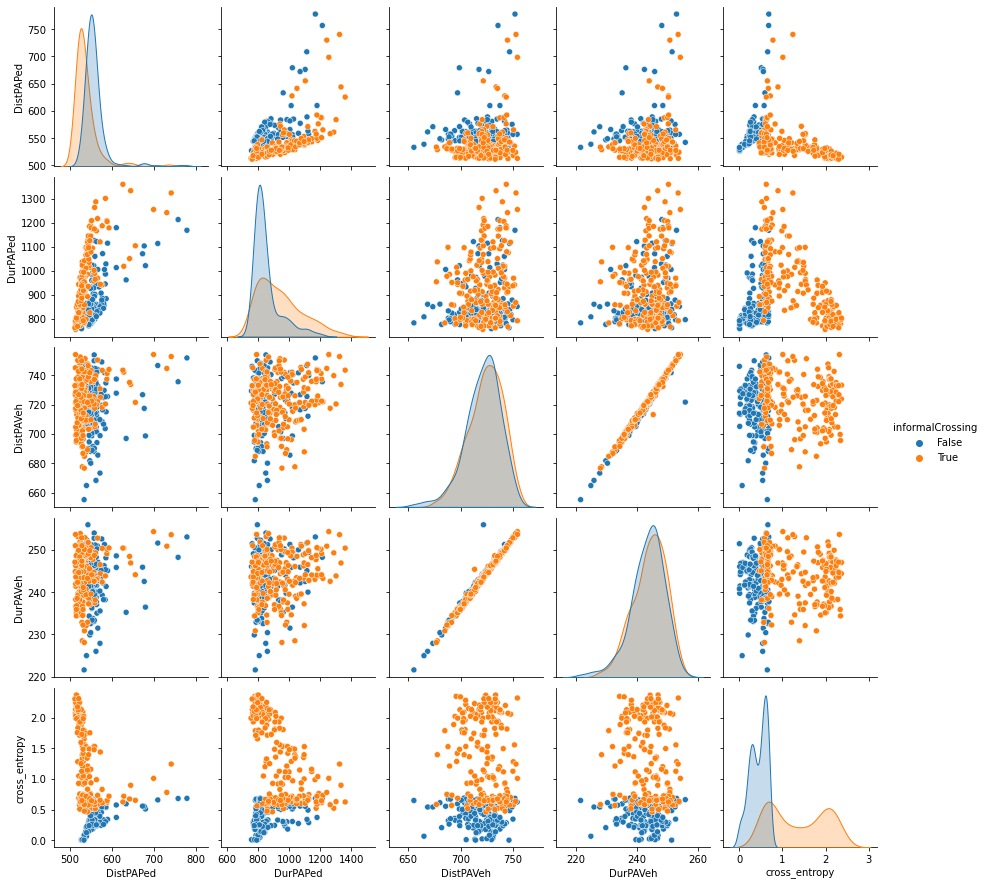

In [7]:
#
# Initial exploratory analysis of multiple outcomes
#

experiments = dfDD.loc[:, params]

outcome_vars = ['DistPAPed','DurPAPed', 'DistPAVeh', 'DurPAVeh', 'cross_entropy']

# Create pairs plot
data = dfDD.loc[:, outcome_vars]
data['informalCrossing'] = experiments['informalCrossing']
sns.pairplot(data, hue='informalCrossing', vars=outcome_vars)

# Scenario Discovery

Trying out scenario discovery analysis. This is where output metrics are compared between policy conditions in order to see which parameters are important for determining differences between policies

## Get policy difference data

In [8]:
# get policy parameter and split the data into groups for different policies
policy_param = list(policies.keys())[0]
policy_values = policies[policy_param]
scenario_param_cols =  [i for i in params if i!=policy_param]

# Now group by scenario and aggregate to find difference in outputs between policy conditions
for c in scenario_param_cols:
	dfDD[c] = dfDD[c].astype(str) # Helps with grouping, makes matching doubles easier

dfPolicyDiff = dfDD.groupby(scenario_param_cols).agg( 	PedDistDiff = pd.NamedAgg(column = "DistPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDistDiff = pd.NamedAgg(column = "DistPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														PedDurDiff = pd.NamedAgg(column = "DurPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDurDiff = pd.NamedAgg(column = "DurPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														CrossEntDiff = pd.NamedAgg(column = "cross_entropy", aggfunc=lambda s: s.values[0] - s.values[1]),
														PedDistDiffFrac = pd.NamedAgg(column = "DistPAPed", aggfunc=lambda s: (s.values[0] - s.values[1]) / s.values[0]),
														CrossEntDiffFrac = pd.NamedAgg(column = "cross_entropy", aggfunc=lambda s: (s.values[0] - s.values[1]) / s.values[0]),
														CountRuns = pd.NamedAgg(column = "run", aggfunc=lambda s: s.shape[0]),
														RunsStr = pd.NamedAgg(column = "run", aggfunc=lambda s: ":".join(str(i) for i in s.tolist())),
													).reset_index()

for c in scenario_param_cols:
	dfPolicyDiff[c] = dfPolicyDiff[c].astype(float)

# Check that there are expected number of runs per scenario
assert (dfPolicyDiff['CountRuns']==2).all()

# Identify successfull scenarios, categorise into two groups
dfPolicyDiff['success'] = (dfPolicyDiff['PedDistDiffFrac'] > -0.1) & (dfPolicyDiff['CrossEntDiffFrac']<0) # crossing is more ordered and pedestrian trips not made too much longer on average
dfPolicyDiff['ent_decreased'] = dfPolicyDiff['CrossEntDiffFrac']<0 

print(dfPolicyDiff['success'].value_counts())
print(dfPolicyDiff['ent_decreased'].value_counts())

True     196
False      4
Name: success, dtype: int64
True     196
False      4
Name: ent_decreased, dtype: int64


C:\Users\OBISAR~1\AppData\Local\Temp/ipykernel_65548/2260077899.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  CrossEntDiffFrac = pd.NamedAgg(column = "cross_entropy", aggfunc=lambda s: (s.values[0] - s.values[1]) / s.values[0]),


## Analyse using tools in ema workbench

In [9]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim

assert config['setting'] == 'latin' # expect LH desig to be used when doing SD

ModuleNotFoundError: No module named 'ema_workbench'

In [ ]:
#
# PRIM analysis requires a boolean outcome variable
#
# select parameters that actually varied
varied_scenario_param_cols = [i for i in scenario_param_cols if params[i]['type']=='list']

# Now use PRIM to identify what determines policy success/failure most
x = dfPolicyDiff.loc[:, varied_scenario_param_cols].copy()
y = dfPolicyDiff['ent_decreased'].values

# Round values to make visualisations clearer
for c in ['epsilon','lambda','alpha', 'tacticalPlanHorizon']:
	x[c] = x[c].map(lambda x: np.round(x, 4))
    
prim_alg = prim.Prim(x, y, threshold=0.5)
box1 = prim_alg.find_box()

In [ ]:
dfPolicyDiff['success'].value_counts()

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()

In [ ]:
box1.inspect(style='graph')

In [ ]:
box1.show_pairs_scatter()

In [ ]:
box2 = prim_alg.find_box()

In [ ]:
box2.show_pairs_scatter()

In [ ]:
box2.inspect()

# Sensitivity analysis of distance and crossing location entropy outputs

Determining which parameters outcomes are most sensitive to in each policy setting by calculating Sobol indices.

Also evaluating which parameter values lead to which outcome values using a regression tree model. Also demonstrating that parameters have non linear effect on outcomes by attempting to fit linear model.

In [10]:
from SALib.analyze import sobol

In [11]:
# Need to creater sub problems for each policy
# - no actually, the design samples for each policy using the sme problem
# - so just need to split X and Y into different policy sets

policy_param = list(policies.keys())[0]
policy_values = policies[policy_param]
scenario_param_cols =  [i for i in params if i!=policy_param]

problem = init_problem(params)

In [12]:
# Group by policy setting and calculate sobol indices
dfSIs = pd.DataFrame()
for metric in ['DistPAPed','cross_entropy']:
    for pv in policy_values:
        X = dfDD.loc[dfDD[policy_param]==pv, problem['names']].values
        Y = dfDD.loc[dfDD[policy_param]==pv, metric].values.astype(float)
        if pd.Series(Y).isnull().any():
            print("Null values in utput for {} - {}, skipping".format(cat, metric))
            continue

        Sis = sobol.analyze(problem, Y, calc_second_order=False, num_resamples=100, conf_level=0.95, print_to_console=False, parallel=False, n_processors=None, keep_resamples=False, seed=random_seed)
        df = pd.DataFrame(Sis)
        df['param'] = problem['names']
        df['metric']=metric
        df[policy_param]=pv
        dfSIs = pd.concat([dfSIs, df])

In [14]:
# Visualise these results
def sobol_si_bar_subplot(ax, dfsi, fig_title, xticklabels):
    bar_width=0.4
    x_pos = np.arange(dfsi.shape[0])
    ax.bar(x_pos, dfsi['S1'], width=bar_width, yerr = dfsi['S1_conf'], align='center', label="S1")
    ax.bar(x_pos+bar_width, dfsi['ST'], width=bar_width, yerr = dfsi['ST_conf'], align='center', label="ST")

    ax.set_xticks(x_pos + bar_width / 2)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.legend()

    ax.set_title(fig_title)
    return ax

In [105]:
dfSIs['metric'].value_counts()

DistPAPed        16
cross_entropy    16
Name: metric, dtype: int64

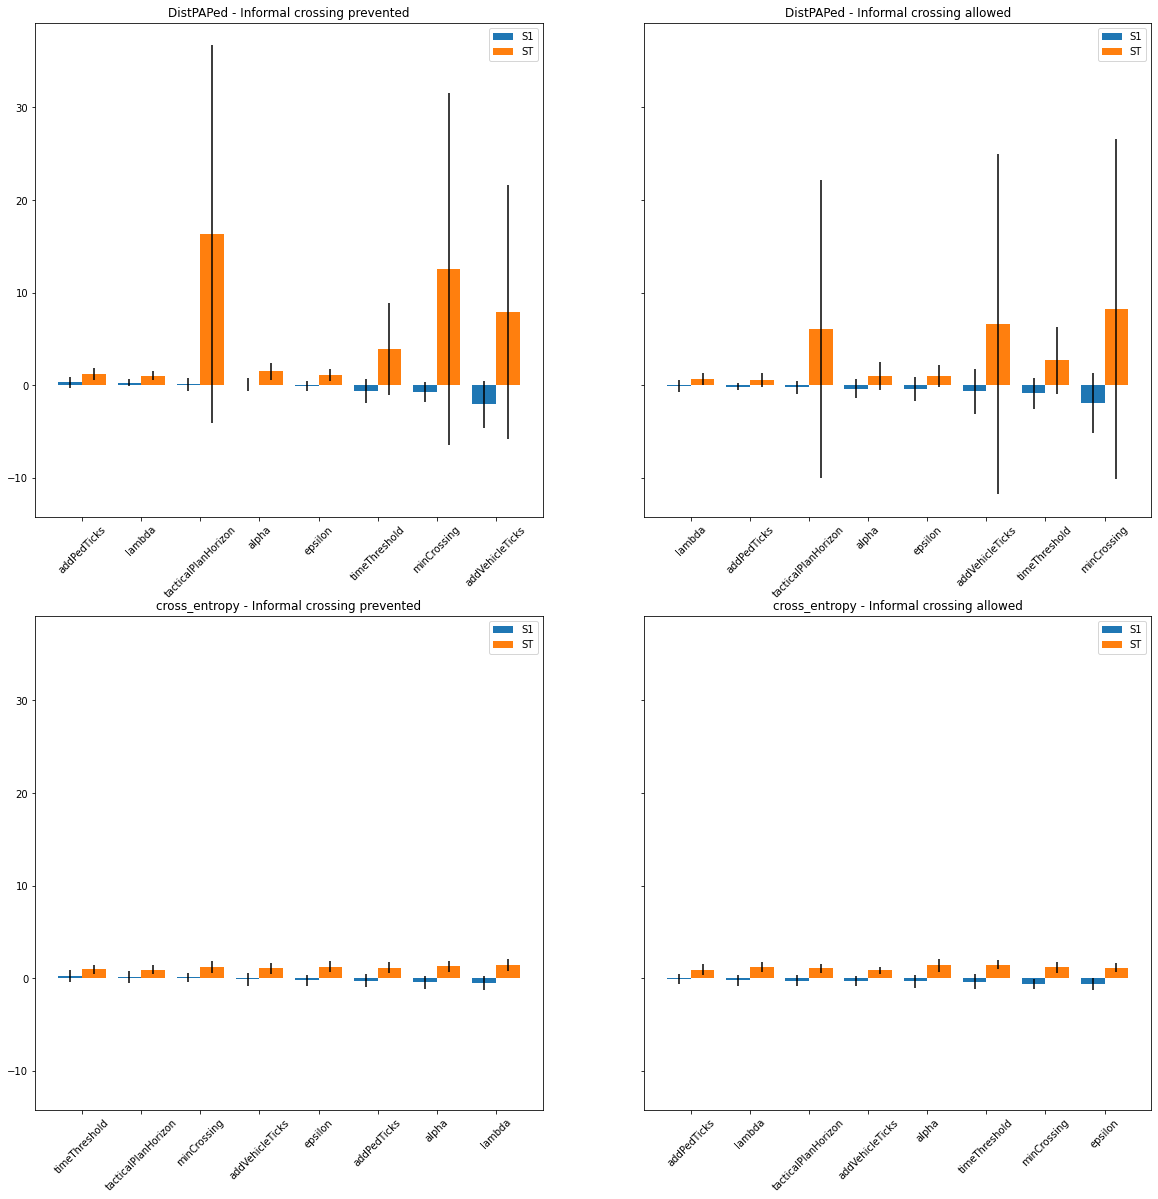

In [107]:
policy_names = {0:"Informal crossing prevented", 1: "Informal crossing allowed"}

f, axs = plt.subplots(2,2, figsize=(20,20), sharey=True)
axs = axs.reshape(1,-1)[0]

grouped = dfSIs.groupby(['metric',policy_param])
for i, (m, pv) in enumerate(grouped.groups.keys()):
    dfsi = grouped.get_group((m, pv)).sort_values(by='S1', ascending=False)
    title = "{} - {}".format(m, policy_names[pv])
    ax = sobol_si_bar_subplot(axs[i], dfsi, title, dfsi['param'])

In [16]:
counts, bins  = np.histogram(dfDD['cross_entropy'], bins=20)
dfDD['mode'] = dfDD['cross_entropy'].map(lambda x: int(x<bins[14]))

In [18]:
# Conver variables to numeric
for c in dfDD.columns:
    if dfDD[c].dtype == 'bool':
        dfDD[c] = pd.Categorical(dfDD[c])
    elif dfDD[c].dtype == 'object':
        dfDD[c] = dfDD[c].astype(float)
    

In [42]:
'''
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # creates the LabelEncoder object
le.fit(['<=50K', '>50K']) # we explicitly encode '<=50k' and '>50k' with 0 and 1, respectively
label_y = le.transform(original_data['over50k']) # runs LabelEncoder on the over50k column
'''

"\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder() # creates the LabelEncoder object\nle.fit(['<=50K', '>50K']) # we explicitly encode '<=50k' and '>50k' with 0 and 1, respectively\nlabel_y = le.transform(original_data['over50k']) # runs LabelEncoder on the over50k column\n"

In [72]:
#from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree, linear_model # for decision tree models
from sklearn.feature_extraction import DictVectorizer

import graphviz # for plotting decision tree graphs

In [73]:
def fitting(X, y, feature_names, criterion, splitter, mdepth, clweight, minleaf):

    # Fit the model
    model = tree.DecisionTreeRegressor(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X, y)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X, y)
    print('Accuracy Score: ', score_tr)
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names, 
                                class_names=None,
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X, y, clf, graph

def fitting_linear_regression(X, y, feature_names):

    # Fit the model
    model = linear_model.LinearRegression( fit_intercept=True)
    clf = model.fit(X, y)
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X, y)
    print('Accuracy Score: ', score_tr)
    print('--------------------------------------------------------')
    
    # Return relevant data for chart plotting
    return X, y, clf

In [80]:
# Tree settings
criterion = 'squared_error'
splitter = 'best'
mdepth = 5
clweight = None
minleaf = 10

In [81]:
model_results = {}
grouped = dfDD.groupby([policy_param])
for i, (pv) in enumerate(grouped.groups.keys()):
    print("\nPolicy Param = {}\n".format(pv))
    df_exp = grouped.get_group((pv))
    
    data_dict = df_exp.loc[:, problem['names']].to_dict('records')
    vec = DictVectorizer()  # create the DictVectorizer object
    vec_array = vec.fit_transform(data_dict).toarray()  # execute process on the record dictionaries and transform the result into a numpy array object
    
    X, y, clf, graph = fitting(vec_array, df_exp['cross_entropy'].values, vec.get_feature_names_out(), criterion, splitter, mdepth, clweight, minleaf)
    model_results[pv] = {'X':X, 'y':y, 'clf':clf, 'graph':graph}


Policy Param = False

*************** Tree Summary ***************
Tree Depth:  5
No. of leaves:  14
No. of features:  8
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8664076220221705
--------------------------------------------------------

Policy Param = True

*************** Tree Summary ***************
Tree Depth:  5
No. of leaves:  13
No. of features:  8
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.9524610708916782
--------------------------------------------------------


Inspect the regression tree results for the different policies

In [103]:
graph_informal = model_results[1]['graph']
graph_informal.format='png'
graph_informal.render(filename='tree_cle_informal', directory=img_dir)

'..\\output\\img\\tree_cle_informal.png'

In [104]:
graph_no_informal = model_results[0]['graph']
graph_informal.format='png'
graph_informal.render(filename="tree_cle_no_informal", directory=img_dir)

'..\\output\\img\\tree_cle_no_informal.png'

In [62]:
# compare feature importances, do these match up with sensitivity indices?
clf_inf = model_results[0]['clf']
clf_no_inf = model_results[1]['clf']
fis = [clf_inf.feature_importances_, clf_no_inf.feature_importances_]

dfF = pd.DataFrame(fis, columns = vec.get_feature_names())
dfF

C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,addPedTicks,addVehicleTicks,alpha,epsilon,lambda,minCrossing,tacticalPlanHorizon,timeThreshold
0,0.0,0.000000,0.084830,0.223881,0.135178,0.000000,0.548266,0.007845
1,0.0,0.001109,0.009338,0.460633,0.159554,0.000343,0.368865,0.000158


Repeat for the distance travelled metric

In [83]:
model_results = {}
grouped = dfDD.groupby([policy_param])
for i, (pv) in enumerate(grouped.groups.keys()):
    print("\nPolicy Param = {}\n".format(pv))
    df_exp = grouped.get_group((pv))
    
    data_dict = df_exp.loc[:, problem['names']].to_dict('records')
    vec = DictVectorizer()  # create the DictVectorizer object
    vec_array = vec.fit_transform(data_dict).toarray()  # execute process on the record dictionaries and transform the result into a numpy array object
    
    X, y, clf, graph = fitting(vec_array, df_exp['DistPAPed'].values, vec.get_feature_names_out(), criterion, splitter, mdepth, clweight, minleaf)
    model_results[pv] = {'X':X, 'y':y, 'clf':clf, 'graph':graph}


Policy Param = False

*************** Tree Summary ***************
Tree Depth:  5
No. of leaves:  11
No. of features:  8
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.737439419707025
--------------------------------------------------------

Policy Param = True

*************** Tree Summary ***************
Tree Depth:  5
No. of leaves:  12
No. of features:  8
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.5349548076118277
--------------------------------------------------------


In [84]:
# compare feature importances, do these match up with sensitivity indices?
clf_inf = model_results[0]['clf']
clf_no_inf = model_results[1]['clf']
fis = [clf_inf.feature_importances_, clf_no_inf.feature_importances_]

dfF = pd.DataFrame(fis, columns = vec.get_feature_names_out())
dfF

,addPedTicks,addVehicleTicks,alpha,epsilon,lambda,minCrossing,tacticalPlanHorizon,timeThreshold
0,0.002485,0.0,0.411590,0.003010,0.559996,0.0,0.018366,0.004553
1,0.000000,0.0,0.753566,0.064177,0.145104,0.0,0.000000,0.037153


In [101]:
graph_informal = model_results[1]['graph']
graph_informal.format='png'
graph_informal.render(filename='tree_dist_informal', directory=img_dir)

'..\\output\\img\\tree_dist_informal.png'

In [102]:
graph_no_informal = model_results[0]['graph']
graph_informal.format='png'
graph_informal.render(filename="tree_dist_no_informal", directory=img_dir)

'..\\output\\img\\tree_dist_no_informal.png'

### Linear regression model just to check whether model is non-linear

In [75]:
metrics = ['DistPAPed', 'cross_entropy']
dist_model_results = {}
grouped = dfDD.groupby([policy_param])
for metric in metrics:
    for i, (pv) in enumerate(grouped.groups.keys()):
        print("\n\nMetric = {}".format(metric))
        print("\nPolicy Param = {}".format(pv))
        df_exp = grouped.get_group((pv))
        data_dict = df_exp.loc[:, problem['names']].to_dict('records')
        vec = DictVectorizer()  # create the DictVectorizer object
        vec_array = vec.fit_transform(data_dict).toarray()  # execute process on the record dictionaries and transform the result into a numpy array object
        X, y, clf = fitting_linear_regression(vec_array, df_exp[metric].values, vec.get_feature_names_out())
        dist_model_results[pv] = {'X':X, 'y':y, 'clf':clf, 'graph':graph}
    




Metric = DistPAPed

Policy Param = False
*************** Evaluation on Training Data ***************
Accuracy Score:  0.3239135581711081
--------------------------------------------------------


Metric = DistPAPed

Policy Param = True
*************** Evaluation on Training Data ***************
Accuracy Score:  0.4933043983789418
--------------------------------------------------------


Metric = cross_entropy

Policy Param = False
*************** Evaluation on Training Data ***************
Accuracy Score:  0.5810232299852874
--------------------------------------------------------


Metric = cross_entropy

Policy Param = True
*************** Evaluation on Training Data ***************
Accuracy Score:  0.662619319269176
--------------------------------------------------------


#### Explaining these results

When agetns minimise numbers of crossings get more ordered crossing locations. This can be explained by agents crossing less frequently, specifically it appears that the types or crossings that get cut out are those in mid block locations since these are more avoidable than crossing at the end of a block, which will tend to be in the same location for many agents.

This pattern may not be reproduced for the grid world since in this case entropy is not so sensitive to the MC parameter.